In [1]:
import time
import torch
import random
import numpy as np
from torch import nn
from torch.functional import F
from matplotlib import pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

In [2]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((32, 32))
    ]
)

In [3]:
train_dataset = FashionMNIST(root='dataset/', train=True, transform=transforms, target_transform=transforms, download=True)
test_dataset = FashionMNIST(root='dataset/', train=False, transform=transforms, target_transform=transforms, download=True)

In [4]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_variance):
        B, C = z_mean.shape
        
        mean = 0
        std = 1
        z_std = 0.5 * torch.exp(z_log_variance)

        eps = torch.normal(mean, std, (B, C))
        eps = eps.to(device)
        z = z_mean + z_std * eps

        return z

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.enc_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2)
        )
        self.enc_5 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2)
        )
        self.sam_1 = Sampling()

    def forward(self, x):
        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        z_mean = self.enc_4(x)
        z_log_variance = self.enc_5(x)
        z = self.sam_1(z_mean, z_log_variance)
        
        return z_mean, z_log_variance, z

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dec_1 = nn.Sequential(
            nn.Linear(in_features=2, out_features=2048),
            nn.Unflatten(dim=1, unflattened_size=(128, 4, 4))
        )
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)
        x = self.dec_5(x)
        
        return x

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(VariationalAutoencoder, self).__init__()

        self.ae_1 = encoder
        self.ae_2 = decoder

    def forward(self, x):
        z_mean, z_log_variance, z = self.ae_1(x)
        reconstruction = self.ae_2(z)
        
        return z_mean, z_log_variance, reconstruction

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [9]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

model = VariationalAutoencoder(encoder, decoder).to(device)

In [10]:
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Flatten-9                 [-1, 2048]               0
           Linear-10                    [-1, 2]           4,098
         Sampling-11                    [-1, 2]               0
          Encoder-12  [[-1, 2], [-1, 2], [-1, 2]]               0
           Linear-13                 [-1, 2048]           6,144
        Unflatten-14            [-1, 

In [11]:
learning_rate = 1e-2
batch_size = 512
start_epoch = 0
epochs = 5

In [12]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class KLDivLoss(nn.Module):
    def __init__(self):
        super(KLDivLoss, self).__init__()

    def forward(self, z_log_variance, z_mean):
        return torch.mean(-0.5 * torch.sum(1 + z_log_variance - torch.pow(z_mean, 2) - torch.exp(z_log_variance), 1))

In [14]:
bce_loss = nn.BCELoss(reduction='none')
kl_div_loss = KLDivLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename, weights_only=True))

In [16]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train_loop(dataloader, model, bce_loss, kl_div_loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (image, label) in enumerate(dataloader):
        i, l = image.to(device), label.to(device)
        z_mean, z_log_variance, reconstruction = model(i)
        
        reconstruction_loss = torch.mean(500 * bce_loss(reconstruction, i))
        kl_loss = kl_div_loss(z_log_variance, z_mean)
        total_loss = reconstruction_loss + kl_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        
    train_loss /= num_batches    
    print(f"Avg. Train loss: {train_loss:>8f}")


# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def test_loop(dataloader, model, bce_loss, kl_div_loss):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (image, label) in enumerate(dataloader):
            i, l = image.to(device), label.to(device)
            z_mean, z_log_variance, reconstruction = model(i)

            reconstruction_loss = torch.mean(500 * bce_loss(reconstruction, i))
            kl_loss = kl_div_loss(z_log_variance, z_mean)
            total_loss = reconstruction_loss + kl_loss
            test_loss += total_loss.item()
            
    test_loss /= num_batches
    print(f"Avg. Test loss: {test_loss:>8f}")

In [17]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"checkpoints/epoch-{resume_epoch}.pth")

for t in range(start_epoch, epochs):
    t0 = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, bce_loss, kl_div_loss, optimizer)
    test_loop(test_dataloader, model, bce_loss, kl_div_loss)
    print(f"Epoch time: {time.time() - t0}\n")
    checkpoint(model, f"checkpoints/epoch-{t}.pth")
print("Done!")

Epoch 1
-------------------------------
Avg. Train loss: 230.167358
Avg. Test loss: 182.760273
Epoch time: 12.76850938796997

Epoch 2
-------------------------------
Avg. Train loss: 178.561381
Avg. Test loss: 177.211237
Epoch time: 13.466276407241821

Epoch 3
-------------------------------
Avg. Train loss: 175.337972
Avg. Test loss: 174.962394
Epoch time: 13.208924055099487

Epoch 4
-------------------------------
Avg. Train loss: 173.949242
Avg. Test loss: 174.349210
Epoch time: 12.699512481689453

Epoch 5
-------------------------------
Avg. Train loss: 173.308856
Avg. Test loss: 174.231548
Epoch time: 12.678284406661987

Done!


In [18]:
subset_indices = [random.randint(0, test_dataset.__len__() - 1) for i in range(10)]
data_subset = Subset(test_dataset, subset_indices)
data_subset_loader = DataLoader(data_subset, batch_size=1, shuffle=True)

In [19]:
def infer_and_plot_results(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch, (image, label) in enumerate(dataloader):
            i, l = image.to(device), label.to(device)
            z_mean, z_log_variance, reconstruction = model(i)

            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
            fig.supylabel(f'Test Output')
            fig.tight_layout()
            
            ax1.imshow(torch.permute(reconstruction[0], (1, 2, 0)).cpu().data.numpy(), cmap='gray')
            ax1.set_title('Prediction')
            ax2.imshow(torch.permute(i[0], (1, 2, 0)).cpu().data.numpy(), cmap='gray')
            ax2.set_title('Reference')

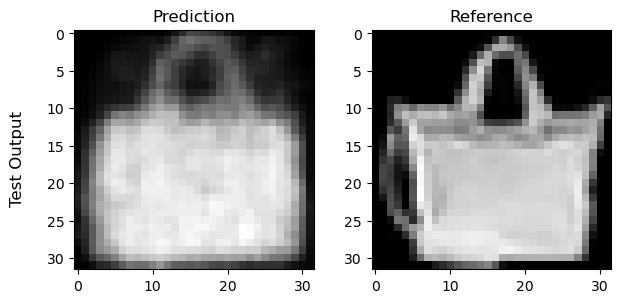

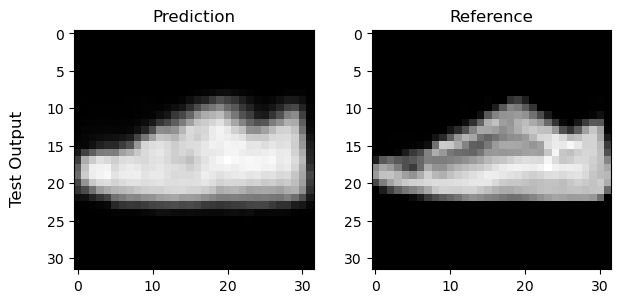

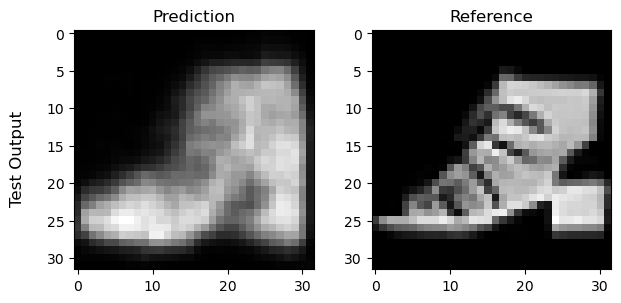

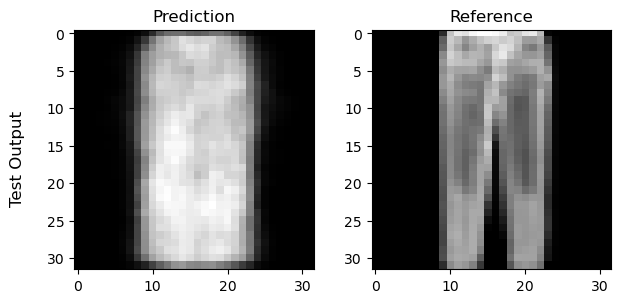

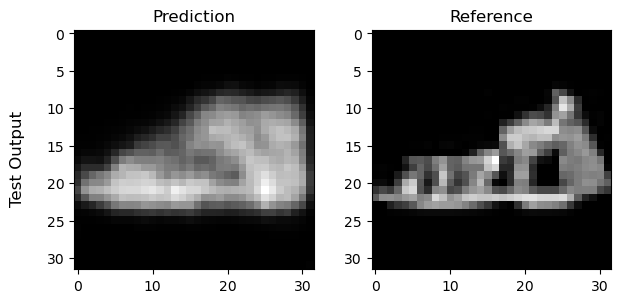

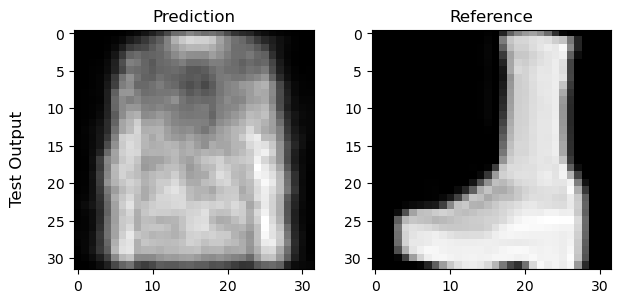

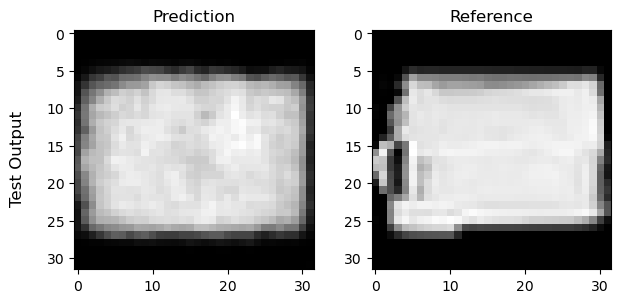

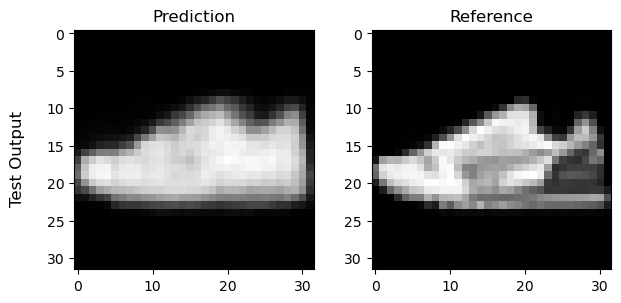

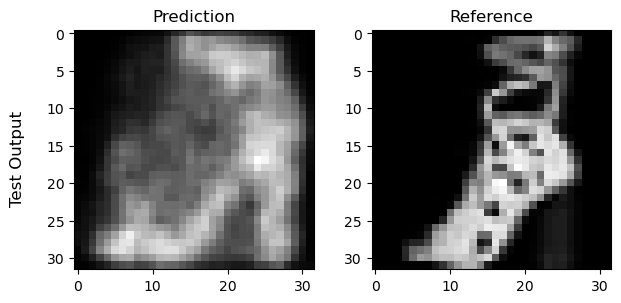

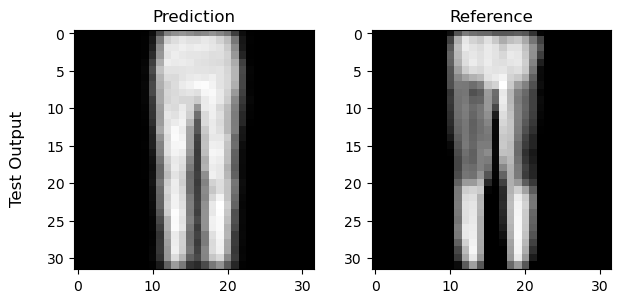

In [20]:
infer_and_plot_results(data_subset_loader, model)

In [21]:
def visualize_latent_space(encoder):
    embeddings = []
    
    for _, (i, _) in enumerate(test_dataloader):
        i = i.to(device)
        z_mean, z_log_variance, z = encoder(i)
        z = z.cpu().data.numpy()
        embeddings.append(z)

    embeddings = np.concatenate(embeddings)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(x=embeddings[:, 0], y=embeddings[:, 1], s=1, alpha=0.5, c='black')
    plt.show()

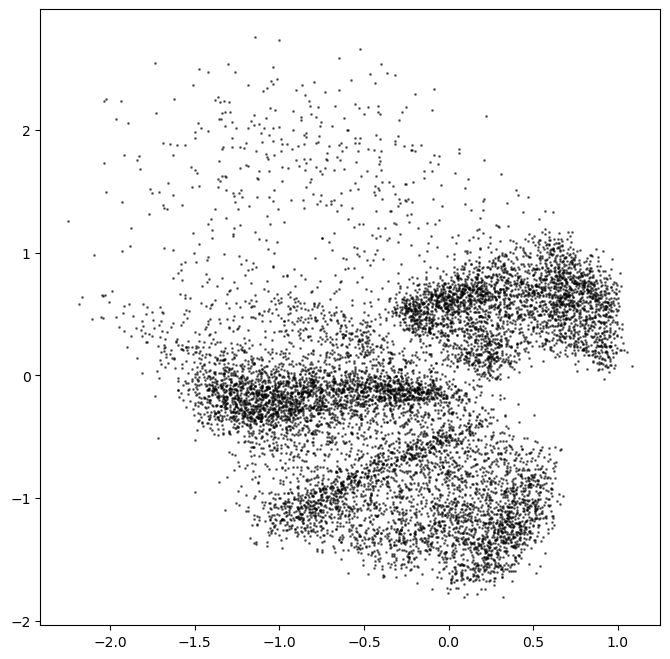

In [22]:
visualize_latent_space(encoder)

In [23]:
def decode_random_sample(decoder):
    embedding = (torch.abs(torch.randn((1, 2))) * 1).to(device)
   
    p = decoder(embedding)
    p = p[0].permute((1, 2, 0)).cpu().data.numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(p, cmap='gray')
    plt.show()

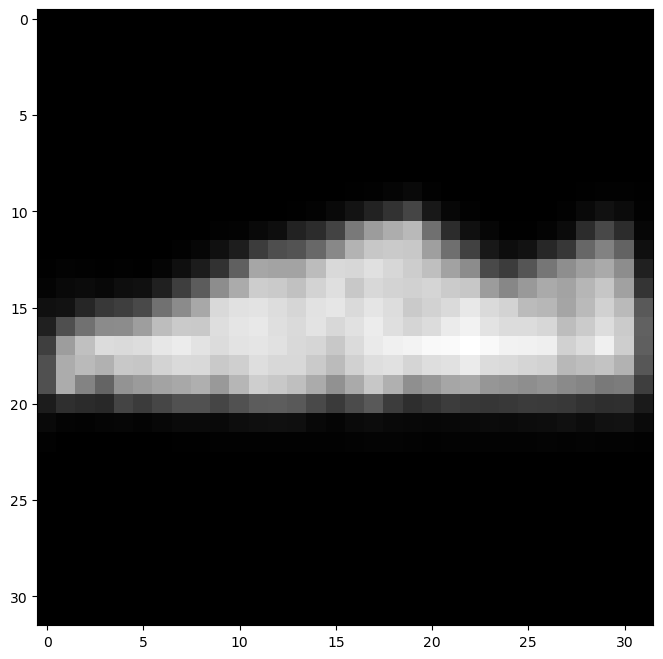

In [25]:
decode_random_sample(decoder)